In [1]:
import sys
import os
from pathlib import Path
from glob import glob
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import matplotlib.patches as patches

In [3]:
from baard.classifiers import get_lightning_module
from baard.utils.torch_utils import get_score
from experiments.eval_features import eval_features

In [4]:
SEED = 727328
PATH_ROOT = Path(os.getcwd()).absolute().parent
PATH_RESULTS = os.path.join(PATH_ROOT, 'results', f'exp{SEED}')
PATH_OUTPUT = os.path.join(PATH_RESULTS, 'whitebox')
if not os.path.exists(PATH_OUTPUT):
    os.makedirs(PATH_OUTPUT)
if not os.path.exists(os.path.join(PATH_RESULTS, 'roc')):
    os.makedirs(os.path.join(PATH_RESULTS, 'roc'))

print(PATH_RESULTS)

/home/lukec/workspace/baard_v4/results/exp727328


In [5]:
def get_auc_df(output_filename, detector_name, data_name, attack_name='whitebox', norm='2'):
    file_dir = os.path.join(PATH_RESULTS, data_name, detector_name, f'{attack_name}-L{norm}')
    path_name = os.path.join(
        file_dir, f'{detector_name}-{data_name}-{attack_name}-L{norm}-*.pt'
    )
    path_files = glob(path_name)
    print(f'Found {len(path_files)} files')
    print(path_files[0])

    eps_list = sorted([Path(f).stem.split('-')[-1] for f in path_files])
    eps_list = sorted([float(i) for i in eps_list[:-1]])
    # print(eps_list)

    files_adv = [f'{detector_name}-{data_name}-{attack_name}-L{norm}-{e}.pt' for e in eps_list]
    file_clean = f'{detector_name}-{data_name}-{attack_name}-L{norm}-clean.pt'
    dataset_adv = [f'whitebox-L{norm}-1000-{e}.pt' for e in eps_list]

    df = pd.DataFrame()
    for file_adv in files_adv:
        _, df_auc_tpr = eval_features(file_dir, os.path.join(PATH_RESULTS, 'roc'), file_clean, file_adv)
        df = pd.concat([df, df_auc_tpr], ignore_index=True)
    df['Epsilon'] = eps_list

    if output_filename:
        df.to_csv(os.path.join(PATH_OUTPUT, output_filename))
    return df


In [6]:
detector_list = [
    'ApplicabilityStage',
    'ReliabilityStage',
    'DecidabilityStage',
    'BAARD',
]
attack_name='whitebox'

Found 9 files
/home/lukec/workspace/baard_v4/results/exp727328/MNIST/ApplicabilityStage/whitebox-L2/ApplicabilityStage-MNIST-whitebox-L2-0.5.pt
Found 9 files
/home/lukec/workspace/baard_v4/results/exp727328/MNIST/ReliabilityStage/whitebox-L2/ReliabilityStage-MNIST-whitebox-L2-2.0.pt
Found 9 files
/home/lukec/workspace/baard_v4/results/exp727328/MNIST/DecidabilityStage/whitebox-L2/DecidabilityStage-MNIST-whitebox-L2-8.0.pt
Found 9 files
/home/lukec/workspace/baard_v4/results/exp727328/MNIST/BAARD/whitebox-L2/BAARD-MNIST-whitebox-L2-1.0.pt


<AxesSubplot: xlabel='Epsilon', ylabel='auc'>

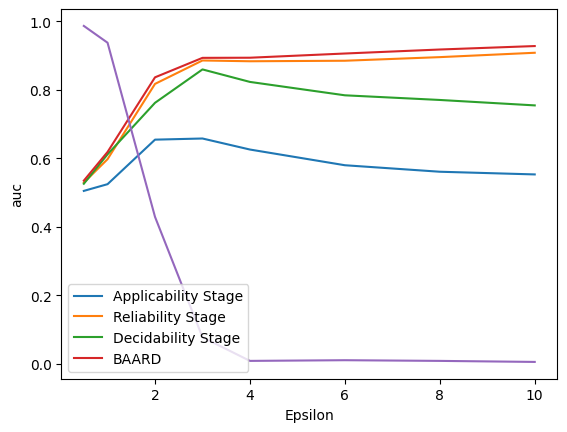

In [7]:
df_s1_mnist_l2 = get_auc_df(f's1_mnist_{attack_name}l2.csv', detector_list[0], 'MNIST', norm=2)
df_s2_mnist_l2 = get_auc_df(f's2_mnist_{attack_name}l2.csv', detector_list[1], 'MNIST', norm=2)
df_s3_mnist_l2 = get_auc_df(f's3_mnist_{attack_name}l2.csv', detector_list[2], 'MNIST', norm=2)
df_all_mnist_l2 = get_auc_df(f'all_mnist_{attack_name}_l2.csv', detector_list[3], 'MNIST', norm=2)

df_s1_mnist_l2['Detector'] = 'Applicability Stage'
df_s2_mnist_l2['Detector'] = 'Reliability Stage'
df_s3_mnist_l2['Detector'] = 'Decidability Stage'
df_all_mnist_l2['Detector'] = 'BAARD'

df1 = pd.concat(
    [df_s1_mnist_l2, df_s2_mnist_l2, df_s3_mnist_l2, df_all_mnist_l2], 
    ignore_index=True)
df1 = df1[['Epsilon', 'Detector', 'auc']]
sn.lineplot(data=df1, x='Epsilon', y='auc', hue='Detector')
df_minst_l2_acc = pd.read_csv(os.path.join(PATH_RESULTS, 'acc','MNIST-whitebox-L2-acc.csv'))
sn.lineplot(data=df_minst_l2_acc, x='eps', y='acc')

Found 11 files
/home/lukec/workspace/baard_v4/results/exp727328/MNIST/ApplicabilityStage/whitebox-Linf/ApplicabilityStage-MNIST-whitebox-Linf-0.4.pt
Found 11 files
/home/lukec/workspace/baard_v4/results/exp727328/MNIST/ReliabilityStage/whitebox-Linf/ReliabilityStage-MNIST-whitebox-Linf-0.16.pt
Found 11 files
/home/lukec/workspace/baard_v4/results/exp727328/MNIST/DecidabilityStage/whitebox-Linf/DecidabilityStage-MNIST-whitebox-Linf-1.0.pt
Found 11 files
/home/lukec/workspace/baard_v4/results/exp727328/MNIST/BAARD/whitebox-Linf/BAARD-MNIST-whitebox-Linf-0.6.pt


/home/lukec/workspace/baard_v4/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<AxesSubplot: xlabel='Epsilon', ylabel='auc'>

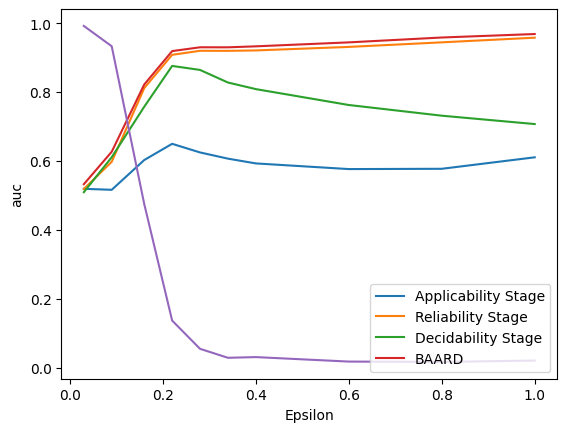

In [8]:
df_s1_mnist_linf = get_auc_df(f's1_mnist_{attack_name}_linf.csv', detector_list[0], 'MNIST', norm='inf')
df_s2_mnist_linf = get_auc_df(f's2_mnist_{attack_name}_linf.csv', detector_list[1], 'MNIST', norm='inf')
df_s3_mnist_linf = get_auc_df(f's3_mnist_{attack_name}_linf.csv', detector_list[2], 'MNIST', norm='inf')
df_all_mnist_linf = get_auc_df(f'all_mnist_{attack_name}_linf.csv', detector_list[3], 'MNIST', norm='inf')

df_s1_mnist_linf['Detector'] = 'Applicability Stage'
df_s2_mnist_linf['Detector'] = 'Reliability Stage'
df_s3_mnist_linf['Detector'] = 'Decidability Stage'
df_all_mnist_linf['Detector'] = 'BAARD'

df2 = pd.concat(
    [df_s1_mnist_linf, df_s2_mnist_linf, df_s3_mnist_linf, df_all_mnist_linf],
    ignore_index=True)
df2 = df2[['Epsilon', 'Detector', 'auc']]

sn.lineplot(data=df2, x='Epsilon', y='auc', hue='Detector')
df_mnist_linf_acc = pd.read_csv(os.path.join(PATH_RESULTS, 'acc', 'MNIST-whitebox-Linf-acc.csv'))
sn.lineplot(data=df_mnist_linf_acc, x='eps', y='acc')


Found 11 files
/home/lukec/workspace/baard_v4/results/exp727328/CIFAR10/ApplicabilityStage/whitebox-L2/ApplicabilityStage-CIFAR10-whitebox-L2-0.2.pt
Found 11 files
/home/lukec/workspace/baard_v4/results/exp727328/CIFAR10/ReliabilityStage/whitebox-L2/ReliabilityStage-CIFAR10-whitebox-L2-0.5.pt
Found 11 files
/home/lukec/workspace/baard_v4/results/exp727328/CIFAR10/DecidabilityStage/whitebox-L2/DecidabilityStage-CIFAR10-whitebox-L2-1.5.pt
Found 11 files
/home/lukec/workspace/baard_v4/results/exp727328/CIFAR10/BAARD/whitebox-L2/BAARD-CIFAR10-whitebox-L2-0.1.pt


<AxesSubplot: xlabel='Epsilon', ylabel='auc'>

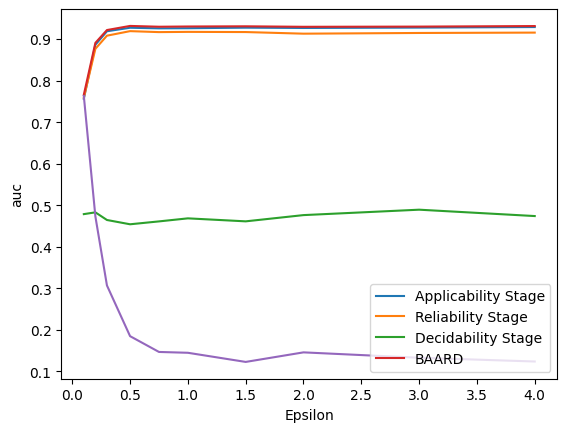

In [9]:
df_s1_cifar10_l2 = get_auc_df(f's1_cifar10_{attack_name}_l2.csv', detector_list[0], 'CIFAR10', norm=2)
df_s2_cifar10_l2 = get_auc_df(f's2_cifar10_{attack_name}_l2.csv', detector_list[1], 'CIFAR10', norm=2)
df_s3_cifar10_l2 = get_auc_df(f's3_cifar10_{attack_name}_l2.csv', detector_list[2], 'CIFAR10', norm=2)
df_all_cifar10_l2 = get_auc_df(f'all_cifar10_{attack_name}_l2.csv', detector_list[3], 'CIFAR10', norm=2)

df_s1_cifar10_l2['Detector'] = 'Applicability Stage'
df_s2_cifar10_l2['Detector'] = 'Reliability Stage'
df_s3_cifar10_l2['Detector'] = 'Decidability Stage'
df_all_cifar10_l2['Detector'] = 'BAARD'

df3 = pd.concat(
    [df_s1_cifar10_l2, df_s2_cifar10_l2, df_s3_cifar10_l2, df_all_cifar10_l2], 
    ignore_index=True)
df3 = df3[['Epsilon', 'Detector', 'auc']]

sn.lineplot(data=df3, x='Epsilon', y='auc', hue='Detector')
df_cifar10_l2_acc = pd.read_csv(os.path.join(PATH_RESULTS, 'acc', 'CIFAR10-whitebox-L2-acc.csv'))
sn.lineplot(data=df_cifar10_l2_acc, x='eps', y='acc')

Found 8 files
/home/lukec/workspace/baard_v4/results/exp727328/CIFAR10/ApplicabilityStage/whitebox-Linf/ApplicabilityStage-CIFAR10-whitebox-Linf-clean.pt
Found 8 files
/home/lukec/workspace/baard_v4/results/exp727328/CIFAR10/ReliabilityStage/whitebox-Linf/ReliabilityStage-CIFAR10-whitebox-Linf-0.01.pt
Found 8 files
/home/lukec/workspace/baard_v4/results/exp727328/CIFAR10/DecidabilityStage/whitebox-Linf/DecidabilityStage-CIFAR10-whitebox-Linf-0.15.pt
Found 8 files
/home/lukec/workspace/baard_v4/results/exp727328/CIFAR10/BAARD/whitebox-Linf/BAARD-CIFAR10-whitebox-Linf-0.2.pt


<AxesSubplot: xlabel='Epsilon', ylabel='auc'>

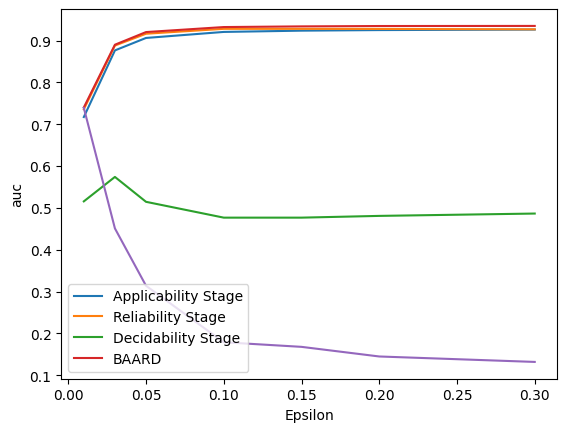

In [10]:
df_s1_cifar10_linf = get_auc_df(f's1_cifar10_{attack_name}_linf.csv', detector_list[0], 'CIFAR10', norm='inf')
df_s2_cifar10_linf = get_auc_df(f's2_cifar10_{attack_name}_linf.csv', detector_list[1], 'CIFAR10', norm='inf')
df_s3_cifar10_linf = get_auc_df(f's3_cifar10_{attack_name}_linf.csv', detector_list[2], 'CIFAR10', norm='inf')
df_all_cifar10_linf = get_auc_df(f'all_cifar10_{attack_name}_linf.csv', detector_list[3], 'CIFAR10', norm='inf')

df_s1_cifar10_linf['Detector'] = 'Applicability Stage'
df_s2_cifar10_linf['Detector'] = 'Reliability Stage'
df_s3_cifar10_linf['Detector'] = 'Decidability Stage'
df_all_cifar10_linf['Detector'] = 'BAARD'

df4 = pd.concat(
    [df_s1_cifar10_linf, df_s2_cifar10_linf, df_s3_cifar10_linf, df_all_cifar10_linf], 
    ignore_index=True)
df4 = df4[['Epsilon', 'Detector', 'auc']]

sn.lineplot(data=df4, x='Epsilon', y='auc', hue='Detector')
df_cifar10_linf_acc = pd.read_csv(os.path.join(PATH_RESULTS, 'acc', 'CIFAR10-whitebox-Linf-acc.csv'))
sn.lineplot(data=df_cifar10_linf_acc, x='eps', y='acc')

In [11]:
ibm_color_palette = [
    '#DC257F',
    '#6D88C4',
    '#6C63AC',
    '#F26322',
    '#FCB017',
    
]
sn.color_palette(ibm_color_palette)

[(0.8627450980392157, 0.1450980392156863, 0.4980392156862745),
 (0.42745098039215684, 0.5333333333333333, 0.7686274509803922),
 (0.4235294117647059, 0.38823529411764707, 0.6745098039215687),
 (0.9490196078431372, 0.38823529411764707, 0.13333333333333333),
 (0.9882352941176471, 0.6901960784313725, 0.09019607843137255)]

In [12]:
df1['auc'] = df1['auc'] * 100
df2['auc'] = df2['auc'] * 100
df3['auc'] = df3['auc'] * 100
df4['auc'] = df4['auc'] * 100

df_mnist_linf_acc['acc'] = df_mnist_linf_acc['acc'] * 100
df_minst_l2_acc['acc'] = df_minst_l2_acc['acc'] * 100
df_cifar10_linf_acc['acc'] = df_cifar10_linf_acc['acc'] * 100
df_cifar10_l2_acc['acc'] = df_cifar10_l2_acc['acc'] * 100

# Sort with baard goes 1st
df1 = df1.sort_values('Detector', key=lambda s: s.apply(['BAARD', 'Applicability Stage', 'Reliability Stage', 'Decidability Stage'].index), ignore_index=True)
df2 = df2.sort_values('Detector', key=lambda s: s.apply(['BAARD', 'Applicability Stage', 'Reliability Stage', 'Decidability Stage'].index), ignore_index=True)
df3 = df3.sort_values('Detector', key=lambda s: s.apply(['BAARD', 'Applicability Stage', 'Reliability Stage', 'Decidability Stage'].index), ignore_index=True)
df4 = df4.sort_values('Detector', key=lambda s: s.apply(['BAARD', 'Applicability Stage', 'Reliability Stage', 'Decidability Stage'].index), ignore_index=True)


[<matplotlib.lines.Line2D object at 0x7f63fc0fad90>, <matplotlib.lines.Line2D object at 0x7f63fc101070>, <matplotlib.lines.Line2D object at 0x7f63fc101310>, <matplotlib.lines.Line2D object at 0x7f63fc1015b0>] ['BAARD', 'Applicability Stage', 'Reliability Stage', 'Decidability Stage']


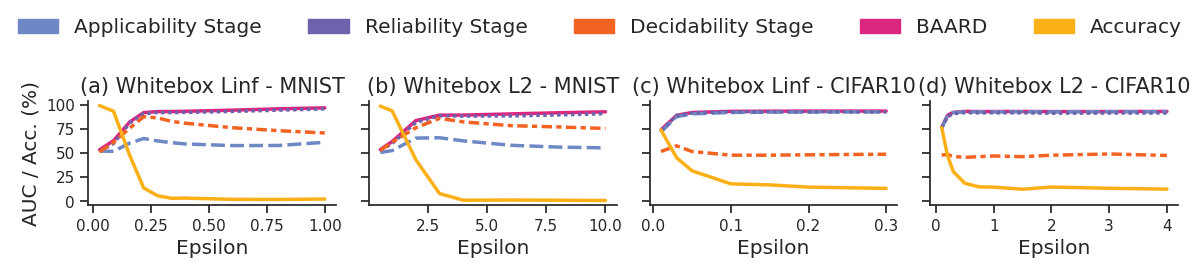

In [14]:

sn.set_theme(
    style='white',
    palette=ibm_color_palette,
)
sn.set_style('ticks')

FONTSIZE = 14.5

plt.rcParams['font.size'] = FONTSIZE
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(12, 2.25))

# linestyles = ['-', ':', '-.', '--']

style_order = [
    'BAARD',
    'Applicability Stage',
    'Reliability Stage',
    'Decidability Stage',
]

sn.lineplot(data=df2, x='Epsilon', y='auc', hue='Detector', ax=axs[0], linewidth=2.5, style_order=style_order, style='Detector')
sn.lineplot(data=df_mnist_linf_acc, x='eps', y='acc', ax=axs[0], linewidth=2.5)
sn.lineplot(data=df1, x='Epsilon', y='auc', hue='Detector', ax=axs[1], linewidth=2.5, style_order=style_order, style='Detector')
sn.lineplot(data=df_minst_l2_acc, x='eps', y='acc', ax=axs[1], linewidth=2.5)
sn.lineplot(data=df4, x='Epsilon', y='auc', hue='Detector', ax=axs[2], linewidth=2.5, style_order=style_order, style='Detector')
sn.lineplot(data=df_cifar10_linf_acc, x='eps', y='acc', ax=axs[2], linewidth=2.5)
sn.lineplot(data=df3, x='Epsilon', y='auc', hue='Detector', ax=axs[3], linewidth=2.5, style_order=style_order, style='Detector')
sn.lineplot(data=df_cifar10_l2_acc, x='eps', y='acc', ax=axs[3], linewidth=2.5)
sn.despine(bottom=False, left=False)

titles = [
    '(a) Whitebox Linf - MNIST',
    '(b) Whitebox L2 - MNIST',
    '(c) Whitebox Linf - CIFAR10',
    '(d) Whitebox L2 - CIFAR10',
]

handles, labels = axs[-1].get_legend_handles_labels()
print(handles, labels)
handles = [patches.Patch(color=handles[i].get_color()) for i in [1, 2, 3, 0]] + [patches.Patch(color=ibm_color_palette[-1])]
labels = labels[1:] + labels[:1] + ['Accuracy']
fig.legend(handles=handles, labels=labels, loc='lower left',
           bbox_to_anchor=(0, 1, 1, 0), mode="expand", ncol=5, fontsize=FONTSIZE
           ).get_frame().set_linewidth(0)
axs[0].set_ylabel('AUC / Acc. (%)', fontsize=FONTSIZE)
plt.yticks(np.linspace(0, 100, 5))
for i, title in enumerate(titles):
    axs[i].set_title(title, fontsize=FONTSIZE + 0.5)
    axs[i].get_legend().remove()
    axs[i].set_xlabel('Epsilon', fontsize=FONTSIZE)

plt.tight_layout()
plt.savefig('whitebox.pdf', dpi=300, bbox_inches='tight')
